In [1]:
packages <- c("survRM2", "mvtnorm", "ggplot2", "MASS", "tidyr", "survival", "nph", "tidyverse",
              "foreach", "doParallel", "cowplot", "IRdisplay", "rlang", "simtrial", "ggrepel")

install_and_load <- function(package) {
  if (!require(package, character.only = TRUE)) {
    install.packages(package)
    library(package, character.only = TRUE)
  }
}

invisible(lapply(packages, install_and_load))

n_cores <- detectCores()
cluster <- makeCluster(16)  
registerDoParallel(cluster)
# multi thread
invisible(clusterEvalQ(cluster, #import packages to parallel 
  {
  library('survRM2')
  library('mvtnorm')
  library('cubature')
  library('survival')
  library('nph')
  library("simtrial")
  library("foreach")
  }))

source('Rfiles/3m_comparison.R')
source('Rfiles/Function.R')
clusterExport(cluster, "expo_gen_2stages")


Loading required package: survRM2

Loading required package: survival

Loading required package: mvtnorm

Loading required package: ggplot2

Loading required package: MASS

Loading required package: tidyr

Loading required package: nph

Loading required package: tidyverse

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::%||%()   masks base::%||%()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::select() masks MASS::select()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: foreach


Attaching package: ‘foreach’


The following objects are masked from ‘package:purrr’:

    accumulate, when


Loading required pac

## 1. Late Difference
#### $HR1 = 1, HR2 = 0.5$
####  $\textcolor{yellow}{H_0 : \lambda_0 = \lambda_1 = 1.2}$    
####  $\textcolor{yellow}{H_1 : \lambda_0 = 1.2,\ \lambda_1 = Piecewise\ Exponential}$
#### <span style="color:yellow">with a HR of 1 until around 1 year and then a HR of 0.5 onward.


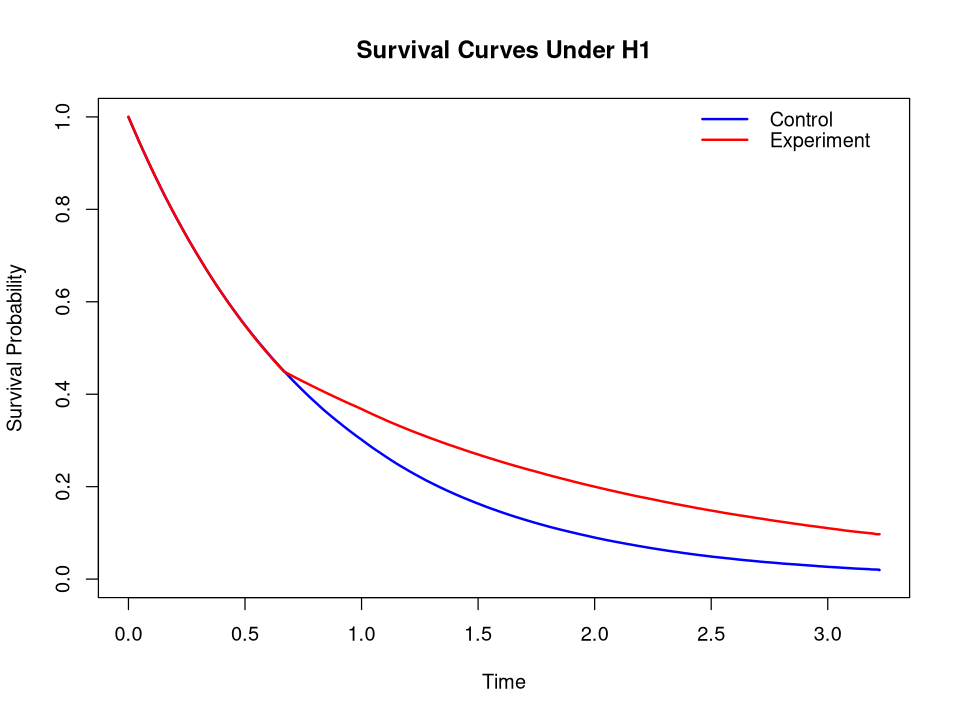

In [2]:
lambda_H0 <- 1.2
HR1 <- 1
HR2 <- 0.5
sim_size <- 10000 
n <- ceiling(200 / 2) 
r <- 90  # patient recruit rate
acc_time <- 200 / r
cen_time <- 1
interim <- 120 / r
change_time <- acc_time * 0.3 # The time point between HR1 and HR2
set.seed(2024)

data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0,
                         dist = 'exp', cen_time = cen_time, arm = 0, interim = interim)
data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, 
                         dist = 'exp', cen_time = cen_time, arm = 1, interim = interim)                         
data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, 
                          dist = 'pcw_exp', cen_time = cen_time,HR1 = HR1, HR2 = HR2, 
                          change_time = change_time, arm = 1, interim = interim)

pre_data <- rbind(data_C[ , c(4,5,1)], data_E_H1[ , c(4,5,1)])
fit <- survfit(Surv(pre_data[,1], pre_data[,2]) ~ pre_data[,3])

options(repr.plot.width = 8, repr.plot.height = 6)
plot(fit, col = c("blue", "red"), lwd = 2, xlab = "Time", ylab = "Survival Probability", main = "Survival Curves Under H1")
legend("topright", legend = c("Control", "Experiment"), col = c("blue", "red"), lwd = 2, bty = "n")

## 1.  Different Hazard Ratio (HR2)
#### $H0: \lambda_E = \lambda_C = 1.2$ is fixed.
#### $H1: \lambda_C = 1.2,\ \lambda_{E2} = 1.2*HR2$, where $\lambda_{E2}$ is the hazard of period 2. 
#### Fix HR1 = 1, Change HR2

In [3]:
lambda_H0 <- 1.2
HR1 <- 1
sim_size <- 10000 
n <- ceiling(200 / 2) 
r <- 90    # patient recruit rate
acc_time <- 200 / r
cen_time <- 1
interim <- 120 / r
change_time <- acc_time * 0.3  # The time point between HR1 and HR2
set.seed(2024)

alpha <- 0.05

diff_hr2_LD <- foreach(HR2 = seq(0.3, 0.8, by = 0.05), .combine = rbind) %do%
    {
        result <- m3_compare(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
                interim = interim, lambda_H0 = lambda_H0, H1_type = 'NPH', 
                HR1 = HR1, HR2 = HR2, change_time = change_time, alpha = alpha)        
        c(HR2, result$alpha, result$power, result$PET0, result$PET1)      
    }


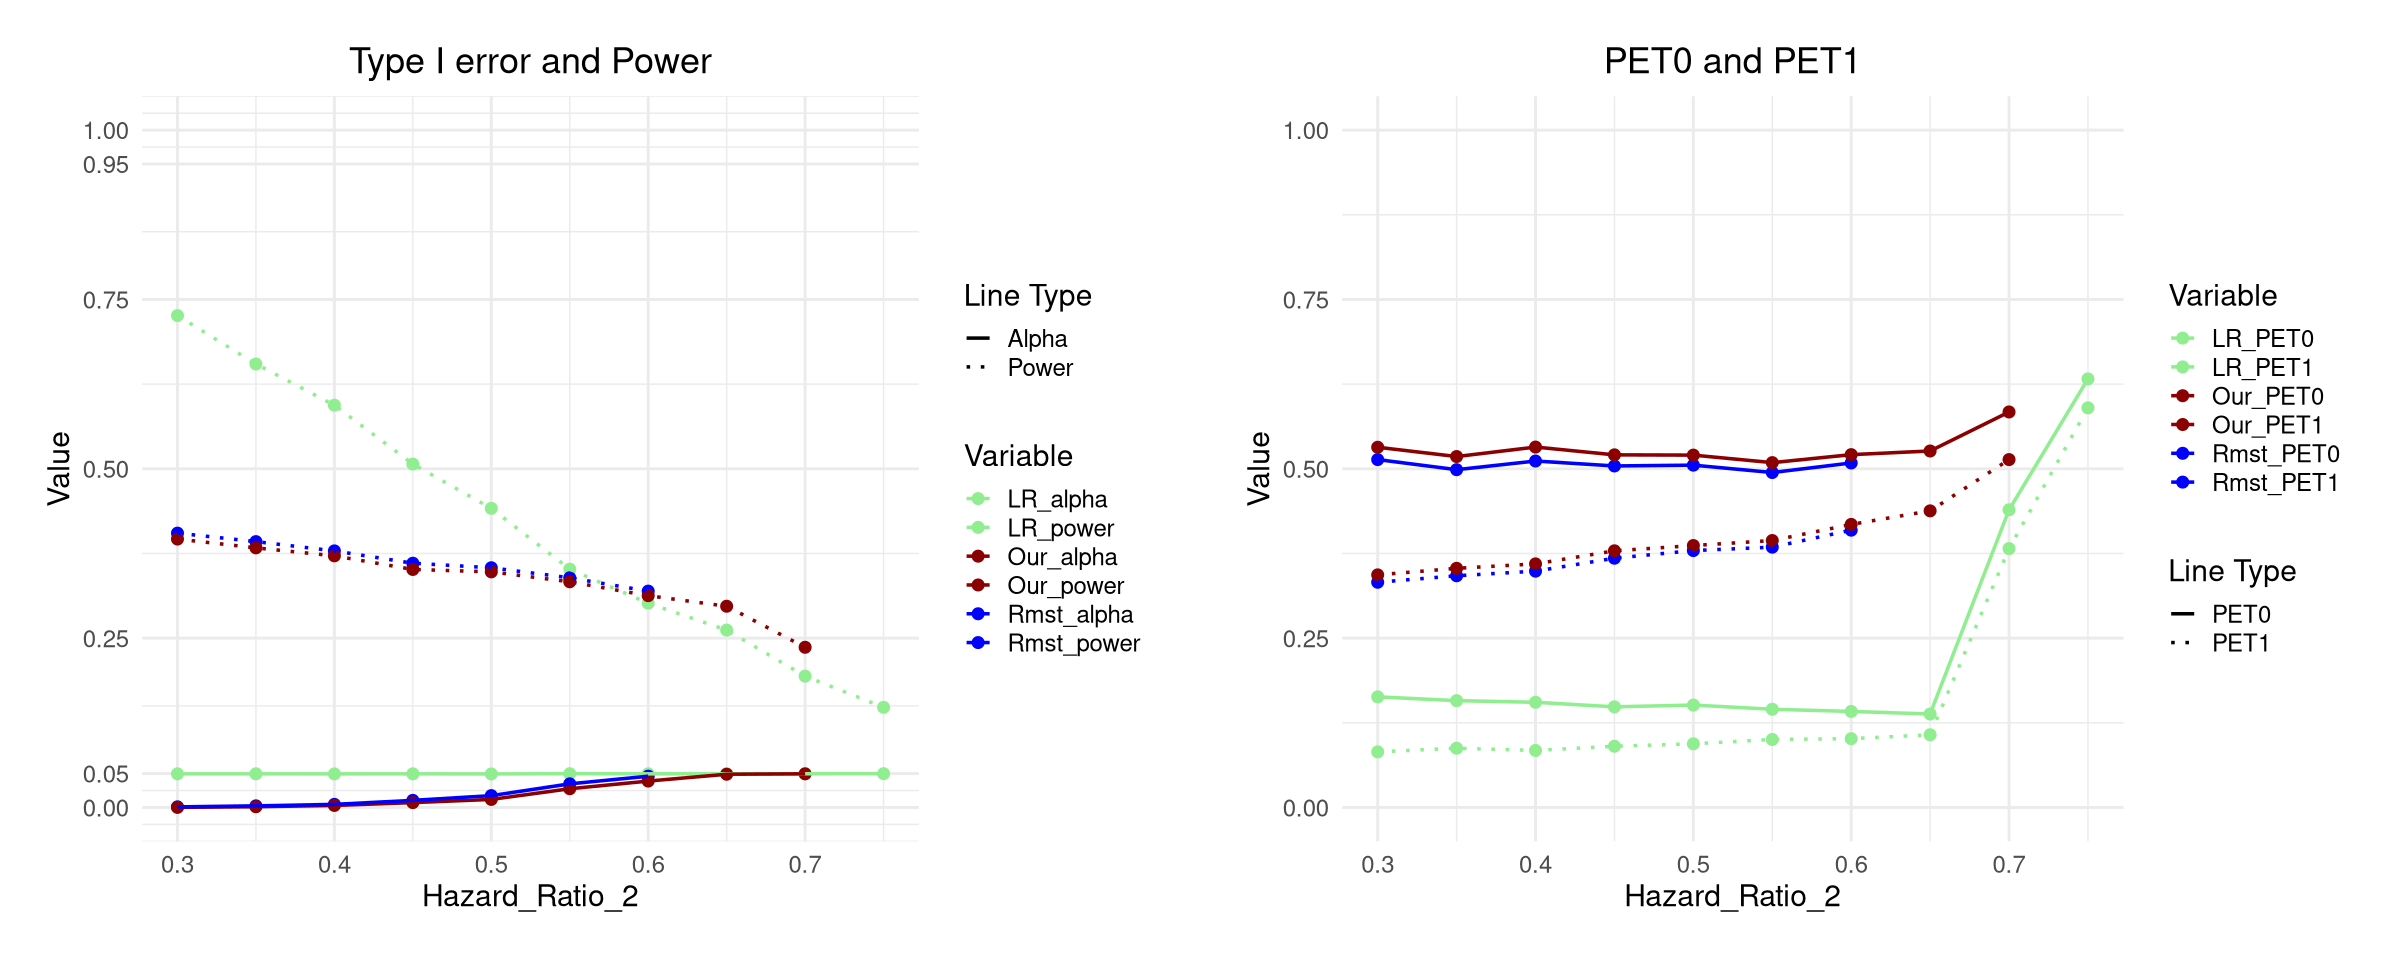

In [4]:
save(diff_hr2_LD, file = '/home/r27user6/RMST_Code/RData/diff_hr2_LD.RData')
load('/home/r27user6/RMST_Code/RData/diff_hr2_LD.RData')

p1 <- compare_line_plot(data = diff_hr2_LD[1:10,], var_name = 'Hazard_Ratio_2')
p1

-----
## 2. Different interim period
#### The changing point of HR is around 0.66 year. If the interim period is too short. The power would be low.


In [5]:
lambda_H0 <- 1.2
HR1 <- 1
HR2 <- 0.5
sim_size <- 10000 
n <- ceiling(200 / 2) 
r <- 90  # patient recruit rate
acc_time <- 200 / r
cen_time <- 1
change_time <- acc_time * 0.3 # The time point between HR1 and HR2
set.seed(2024)

diff_interim_LD <- foreach(int_sam = seq(80, 180, by = 10), .combine = rbind) %do%
    {
        interim <- int_sam / r
        result <- m3_compare(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
                interim = interim, lambda_H0 = lambda_H0, H1_type = 'NPH', 
                HR1 = HR1, HR2 = HR2, change_time = change_time, alpha = alpha)        
        c(interim, result$alpha, result$power, result$PET0, result$PET1)      
      
    }

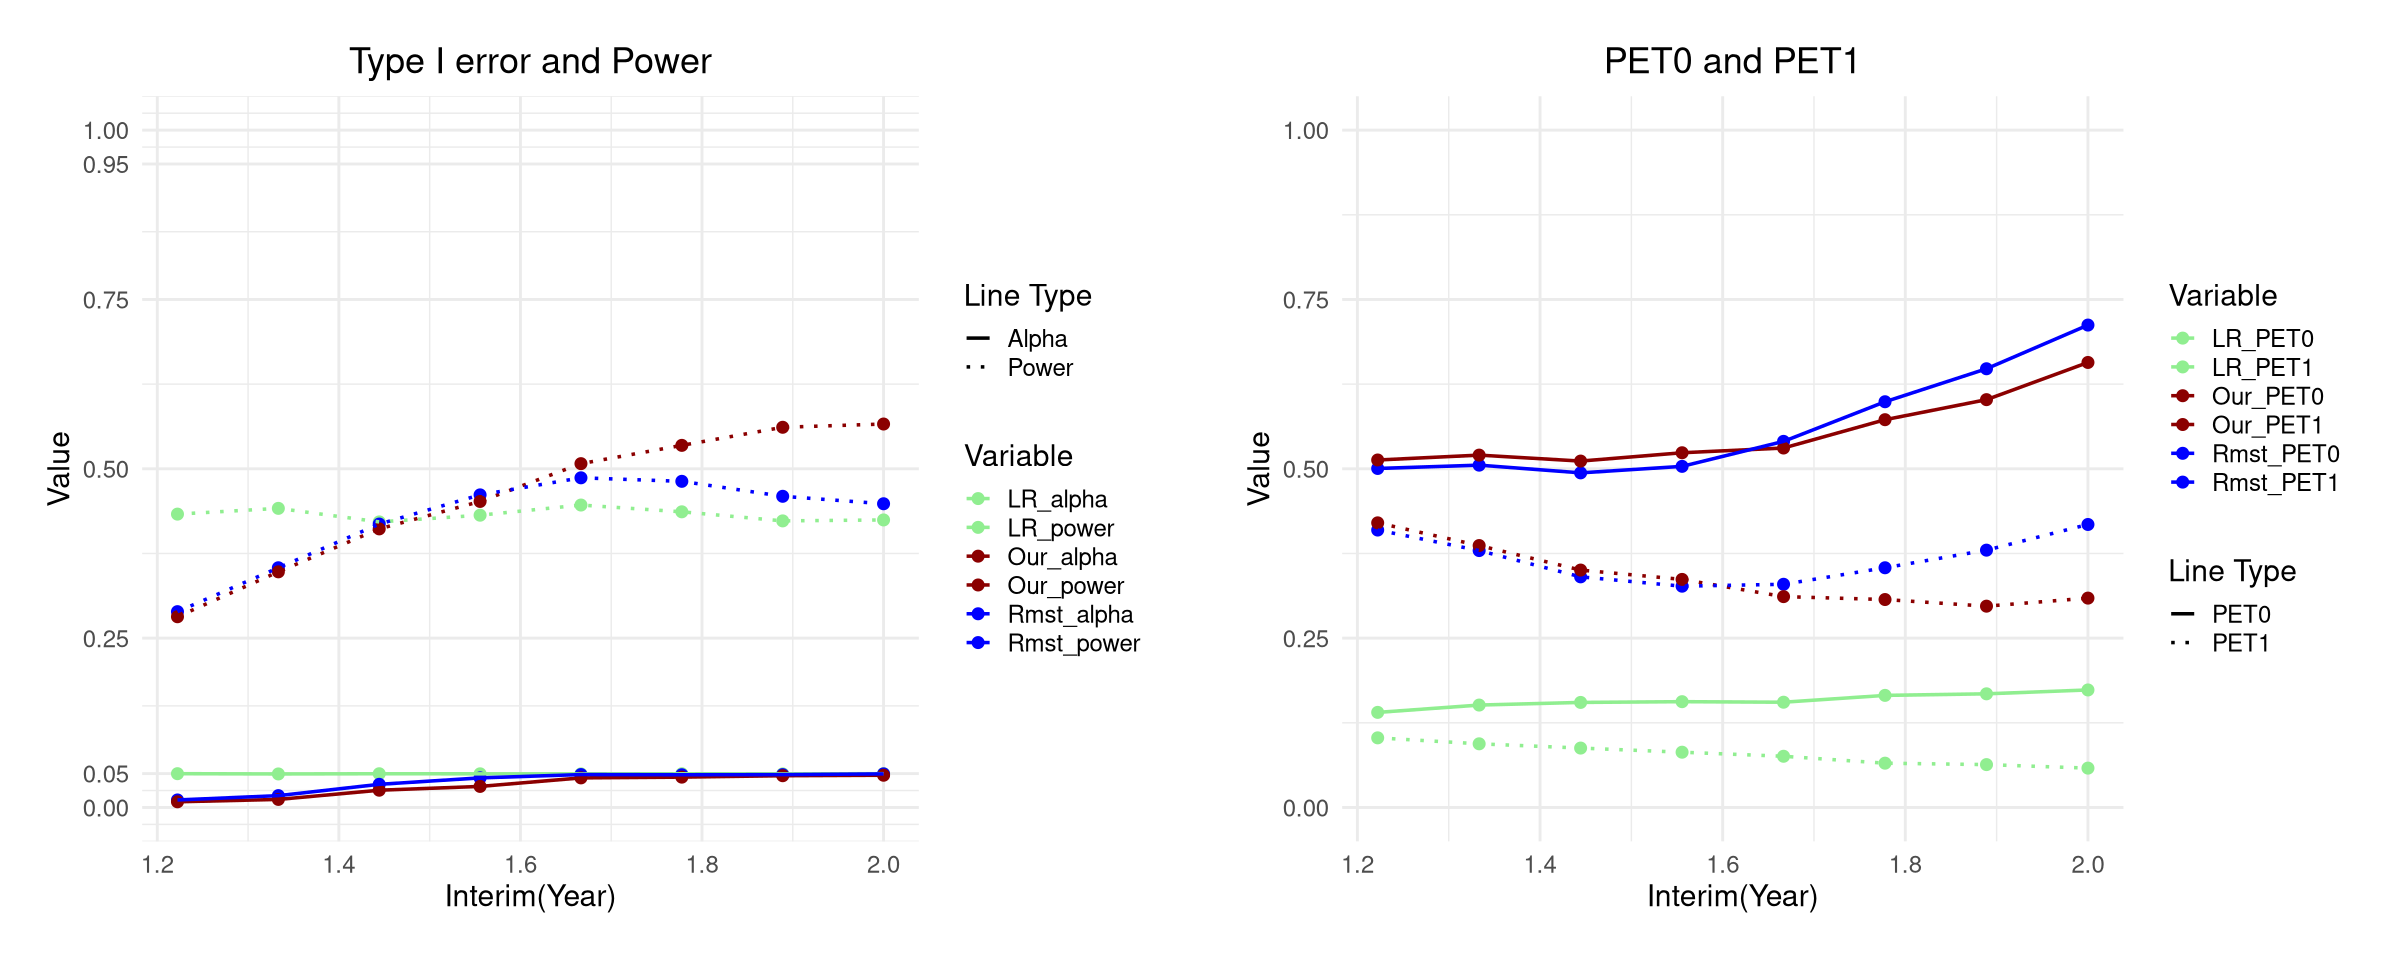

In [6]:
save(diff_interim_LD, file = '/home/r27user6/RMST_Code/RData/diff_interim_LD.RData')
load('/home/r27user6/RMST_Code/RData/diff_interim_LD.RData')

p2 <- compare_line_plot(data = diff_interim_LD[4:11,], var_name = 'Interim(Year)')
p2

------
## 3. Different Recruit Rate
### Constant recruit rate. Smaller value means longer accrual time and interim period

In [7]:
lambda_H0 <- 1.2
HR1 <- 1
HR2 <- 0.6
sim_size <- 10000 
n <- ceiling(200 / 2) 
cen_time <- 1
change_time <- (200 / 90) * 0.3  # The time point between HR1 and HR2
set.seed(2024)
alpha <- 0.05

diff_rec_rate_LD <- foreach(r = seq(40, 130, by = 10), .combine = rbind) %do%
    {
        acc_time <- 200 / r
        interim <- 120 / r 
        result <- m3_compare(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
                interim = interim, lambda_H0 = lambda_H0, H1_type = 'NPH', 
                HR1 = HR1, HR2 = HR2, change_time = change_time, alpha = alpha)        
        c(r, result$alpha, result$power, result$PET0, result$PET1)  
    }

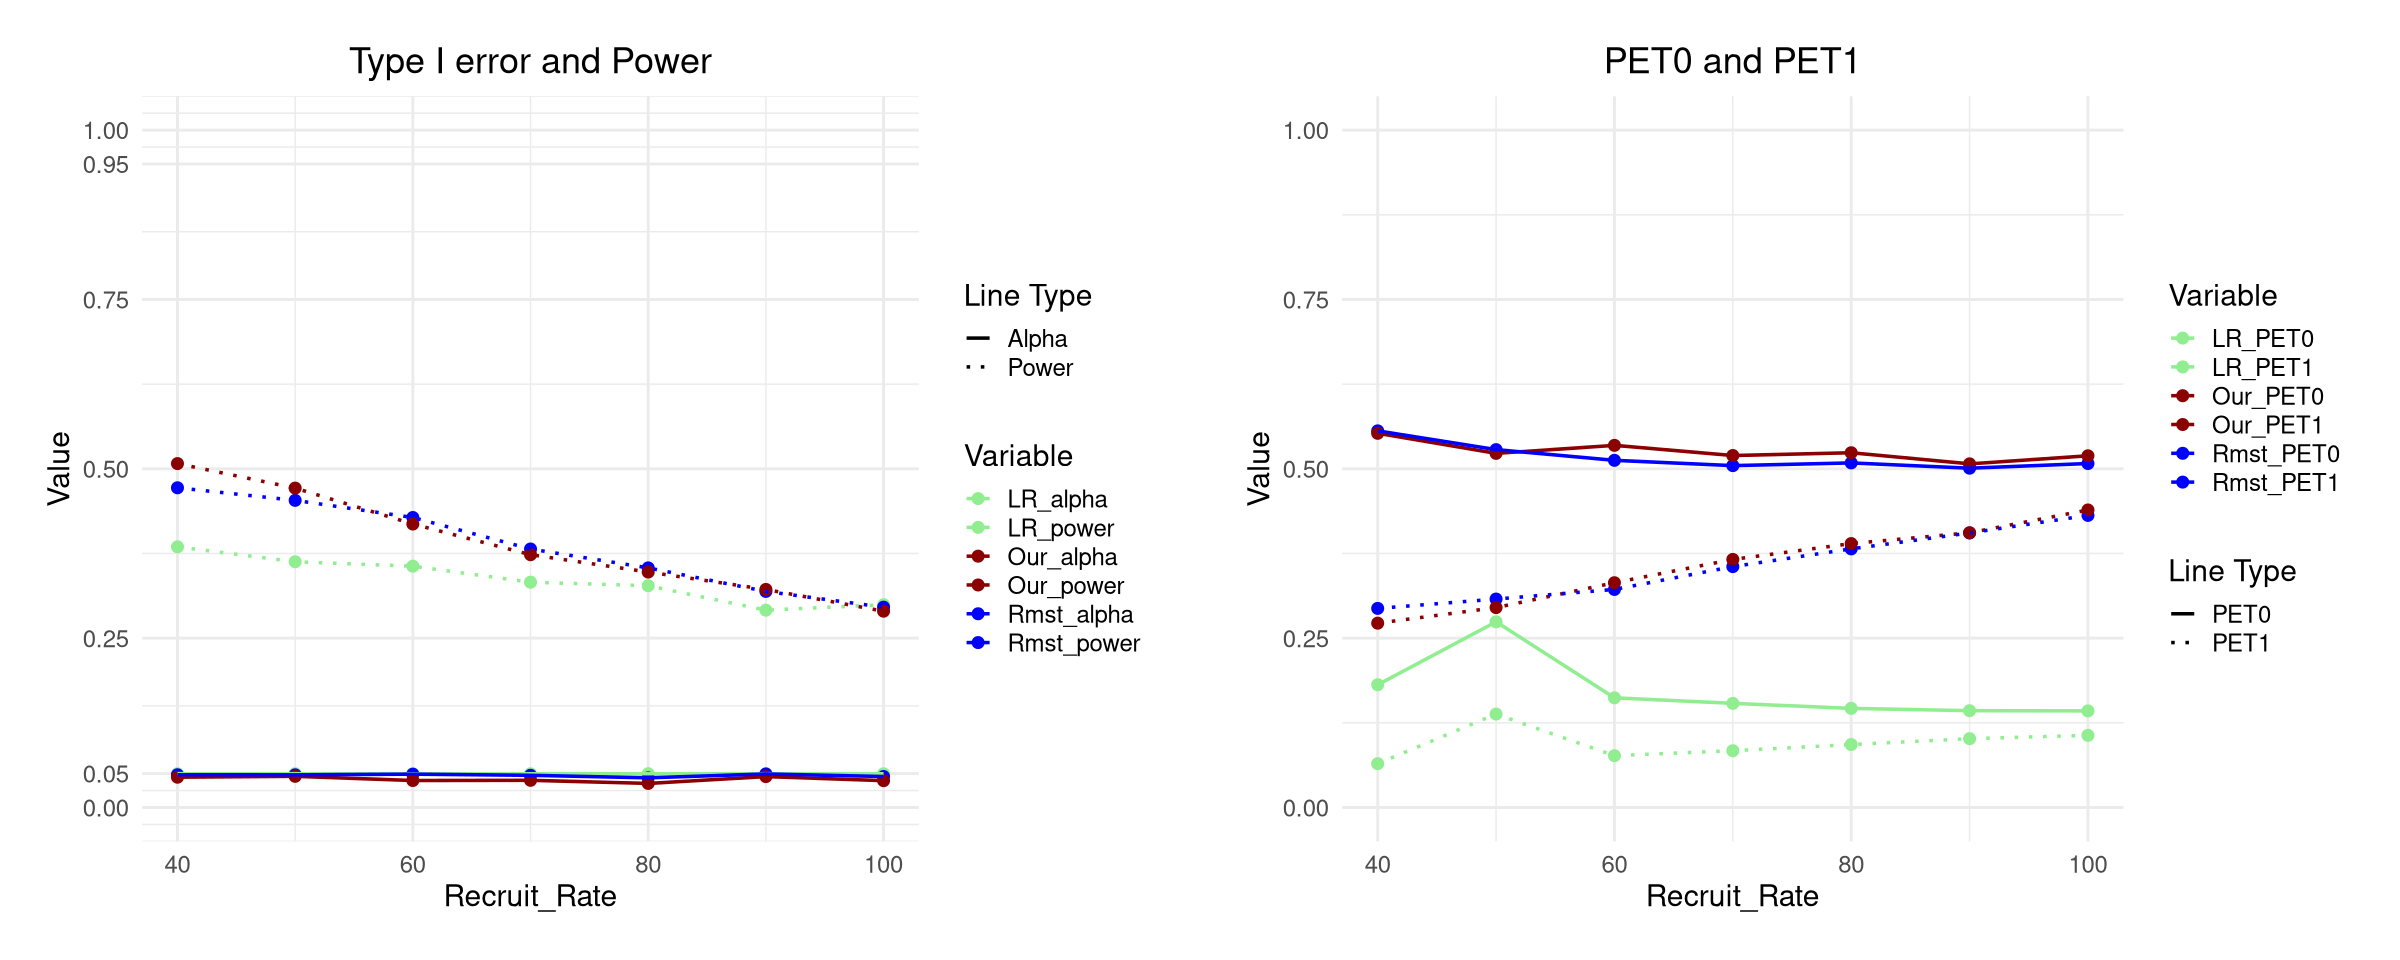

In [8]:
save(diff_rec_rate_LD, file = '/home/r27user6/RMST_Code/RData/diff_rec_rate_LD.RData')
load('/home/r27user6/RMST_Code/RData/diff_rec_rate_LD.RData')

p3 <- compare_line_plot(data = diff_rec_rate_LD[1:7,], var_name = 'Recruit_Rate')
p3

------
## 4. Different Changing Point
#### The time point of HR1 to HR2

In [9]:
lambda_H0 <- 1.2
HR1 <- 1
HR2 <- 0.5
sim_size <- 10000 
n <- ceiling(200 / 2) 
r <- 90  # patient recruit rate
acc_time <- 200 / r
cen_time <- 1
interim <- 120 / r
set.seed(2024)
alpha <- 0.05

diff_ct_LD <- foreach(ct_rate = seq(0.2, 0.6, by = 0.05), .combine = rbind) %do%
    {
        change_time <- acc_time * ct_rate
        result <- m3_compare(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
                interim = interim, lambda_H0 = lambda_H0, H1_type = 'NPH', 
                HR1 = HR1, HR2 = HR2, change_time = change_time, alpha = alpha)        
        c(change_time, result$alpha, result$power, result$PET0, result$PET1)  
    }

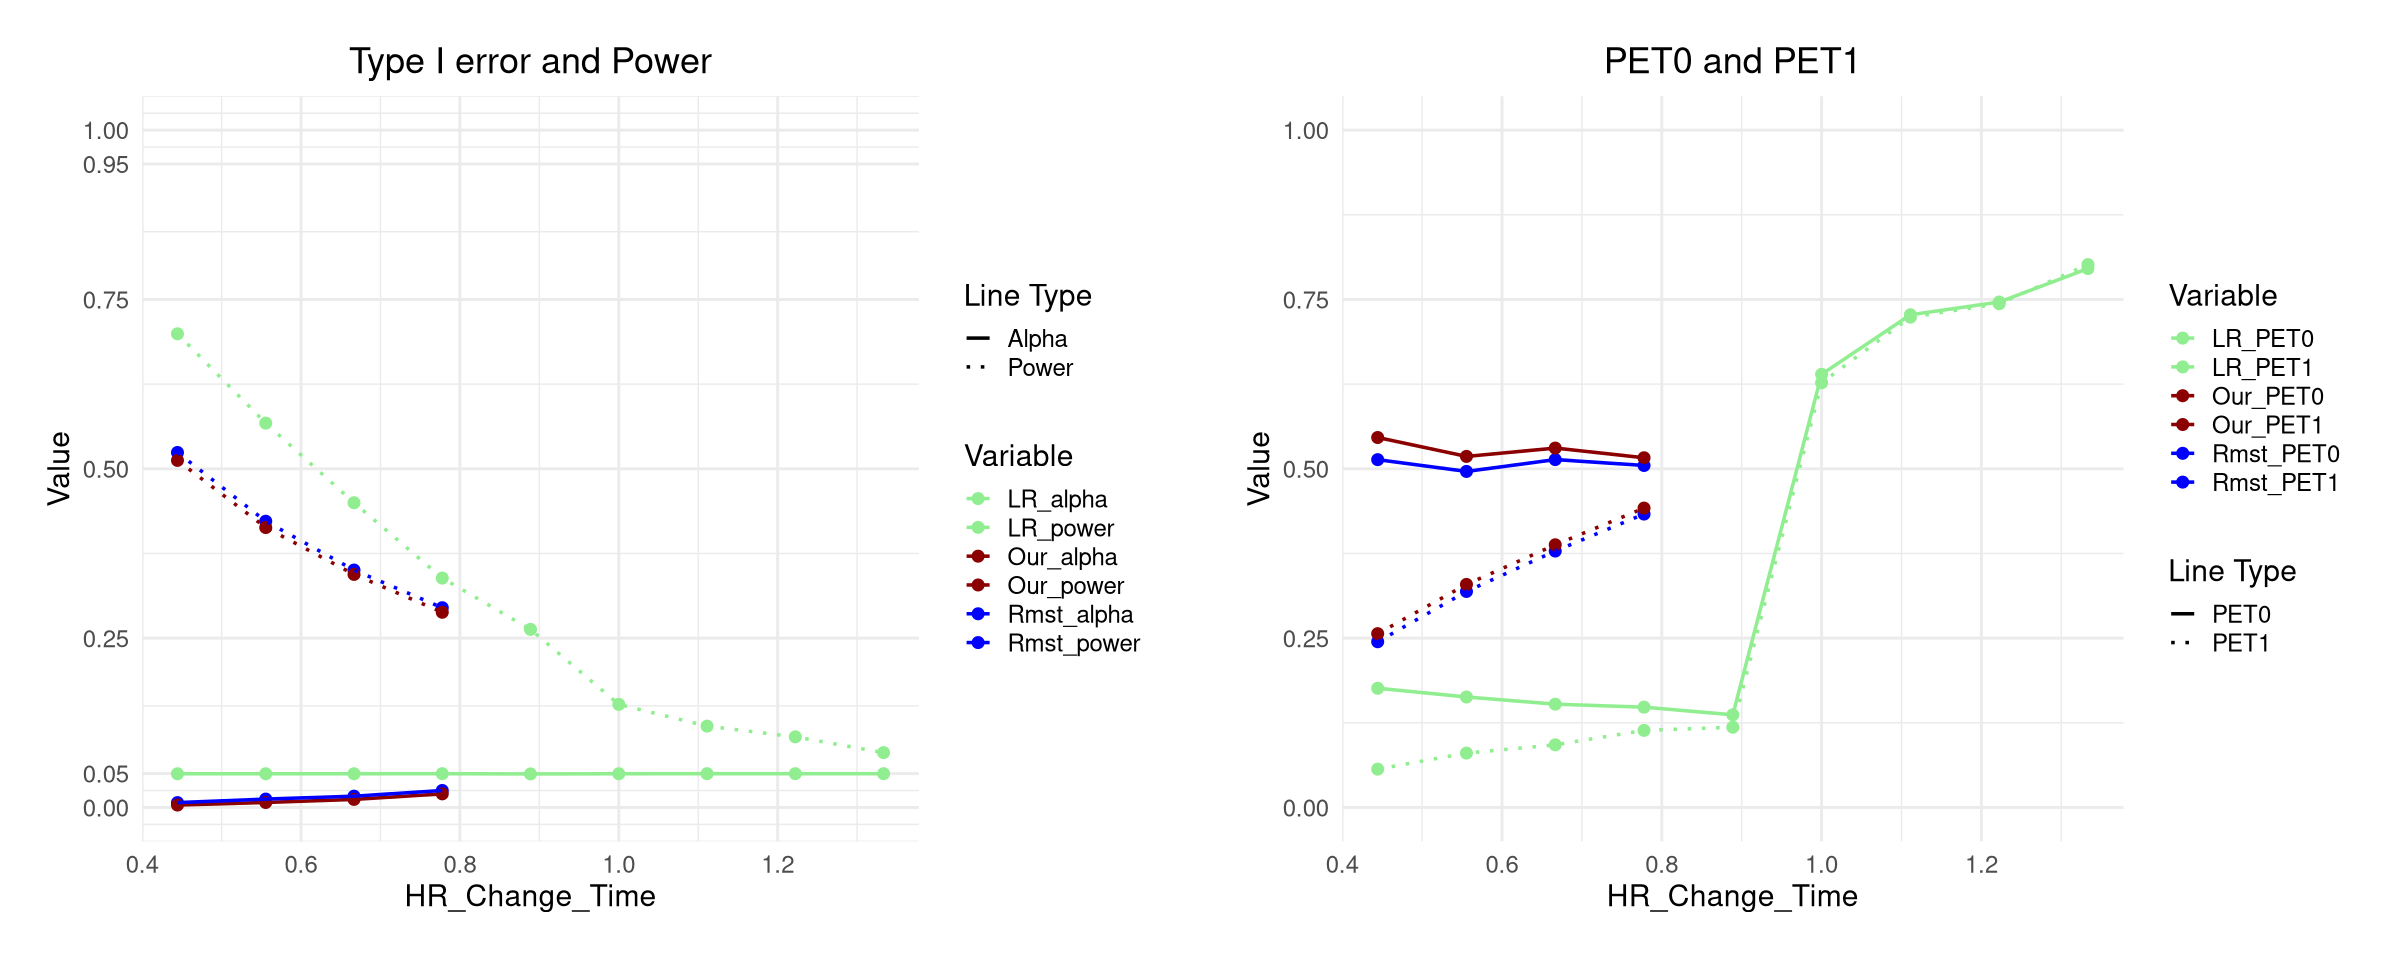

In [10]:
save(diff_ct_LD, file = '/home/r27user6/RMST_Code/RData/diff_ct_LD.RData')
load('/home/r27user6/RMST_Code/RData/diff_ct_LD.RData')

p4 <- compare_line_plot(data = diff_ct_LD, var_name = 'HR_Change_Time')
p4

-----
## 5. Different Follow Up Time : censoring distribution
### Censoring distribution $C \sim U [b , a + b]$, where b is the follow up time.
### We tune b from 0.6 to 1.6

In [11]:
lambda_H0 <- 1.2
HR1 <- 1
HR2 <- 0.5
sim_size <- 10000 
n <- ceiling(200 / 2) 
r <- 90  # patient recruit rate
acc_time <- 200 / r
interim <- 120 / r
change_time <- acc_time * 0.3 # The time point between HR1 and HR2
set.seed(2024)

diff_cen_LD <- foreach(cen_time = seq(0.6, 1.5, by = 0.1), .combine = rbind) %do%
    {
        result <- m3_compare(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
                interim = interim, lambda_H0 = lambda_H0, H1_type = 'NPH', 
                HR1 = HR1, HR2 = HR2, change_time = change_time, alpha = alpha)        
        c(cen_time, result$alpha, result$power, result$PET0, result$PET1)        
    }

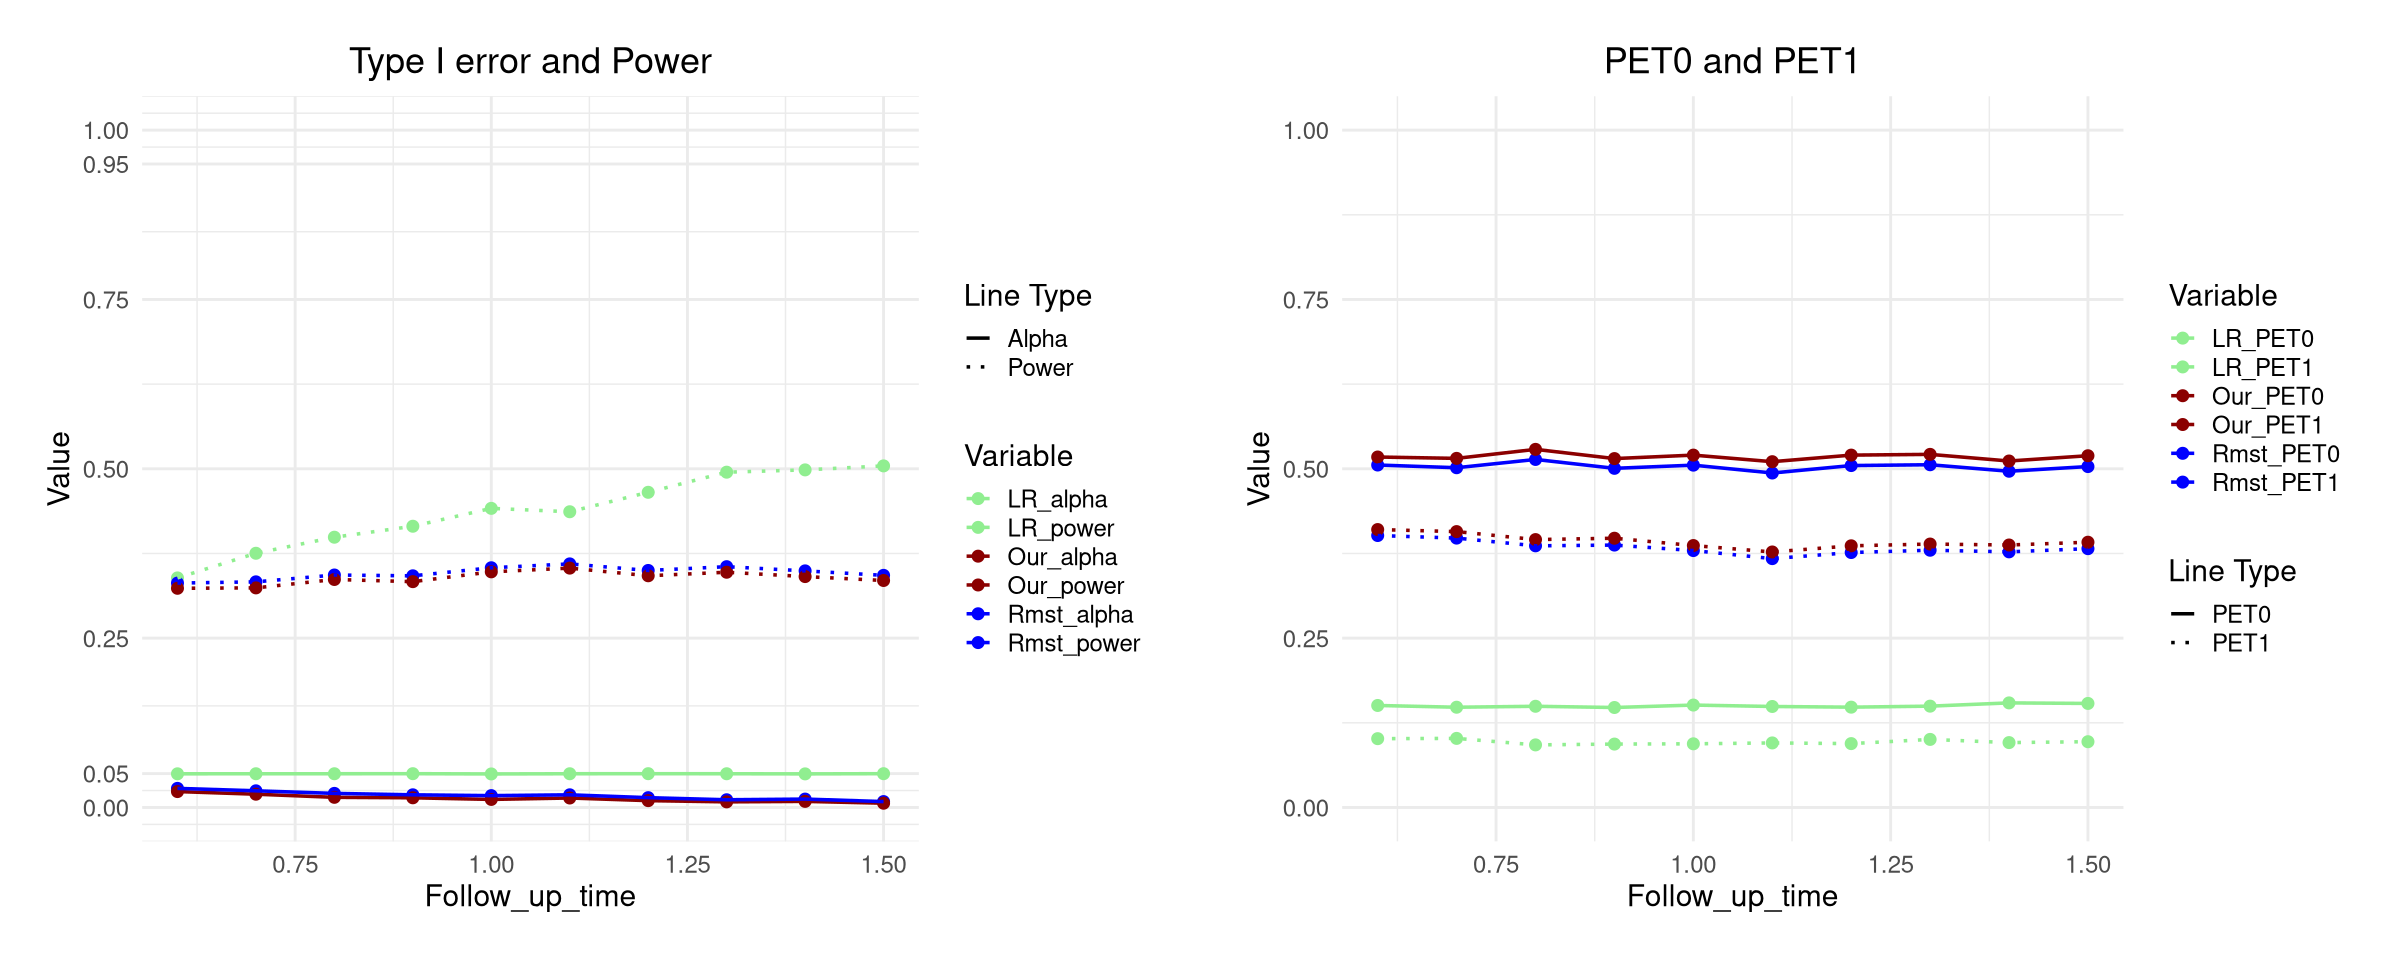

In [12]:
save(diff_cen_LD, file = '/home/r27user6/RMST_Code/RData/diff_cen_LD.RData')
load('/home/r27user6/RMST_Code/RData/diff_cen_LD.RData')

p5 <- compare_line_plot(data = diff_cen_LD, var_name = 'Follow_up_time')
p5

In [13]:
p <- plot_grid(p1,p2,p3,p4,p5, ncol = 1)
ggsave("figures/Comparison/Late_diff.png", plot = p,width = 20, height = 30, limitsize = FALSE)

### the searching range of gamma(in our method) may be too small. no solution